In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 

**Mover urls desse diretório**

In [2]:
dados_treino = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\train.csv")
dados_teste =  pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\test.csv")
feriados = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\holidays_events.csv")
preco_petroleo = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\oil.csv")
lojas = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\stores.csv")
transacoes = pd.read_csv(r"C:\Users\Felipe\Desktop\Projetos Pessoais\store-sales-time-series-forecasting\transactions.csv")


# Preparando os dados para o modelo

Quando estamos preparando modelos de aprendizado de máquina é importante ter em mente que nosso modelo será tão bom quanto os dados que fornecemos para ele. 

A qualidade, a relevância e a integridade dos dados afetam diretamente a capacidade do modelo de aprender e fazer previsões precisas. Portanto, antes de mergulhar na criação de modelos complexos, é essencial dedicar tempo e esforço à preparação adequada dos dados. 



## Adicionando a cotação do petróleo ao dataset

O conjunto dos dados representa os registros de venda de uma rede de lojas do Equador durante um período. A econômia do equador extremamente dependente do petróleo, portanto é interesante apresentar isso ao nosso modelo para que ele consiga detectar qualquer correlação na variação do preço e das vendas.

Para isso foi necessário fazer alguns tratamentos nos dados relacionados ao preço do petróleo.

**Falar sobre covariantes aqui **



#### Tratando dados faltantes para covariante

In [3]:
# Criando um dataset com todas as datas em que queremos análisar as vendas 

total_datas = np.concatenate((dados_treino['date'].unique(),dados_teste['date'].unique()))
nanobj = np.array([np.nan for d in total_datas])
dicio = {'date': total_datas,
        'preco': nanobj }
preco_petroleo_todos = pd.DataFrame(data=dicio)

#Adicionando a cotação do petroleo para todas as datas disponíveis 

for i in preco_petroleo.itertuples():
   for j in preco_petroleo_todos.itertuples():
        if i.date == j.date:
            preco_petroleo_todos.at[j.Index,'preco'] = i.dcoilwtico
            break

#Tratando dias em que a cotação do petroleo não foi registrada.
#um dia com a cotação de petróleo não registrada recebe o valor do próximo dia em que a cotação foi registrada
#Essa forma de tratamento é interessante pois preserva o comportamento do preço durante a série temporal

for i in preco_petroleo_todos.itertuples():
    if np.isnan(i.preco) == True:
        for j in preco_petroleo_todos[i.Index+1:].itertuples():
            if np.isnan(j.preco) == False:
                preco_petroleo_todos.at[i.Index,'preco'] = j.preco
                break
 

<Axes: xlabel='date', ylabel='preco'>

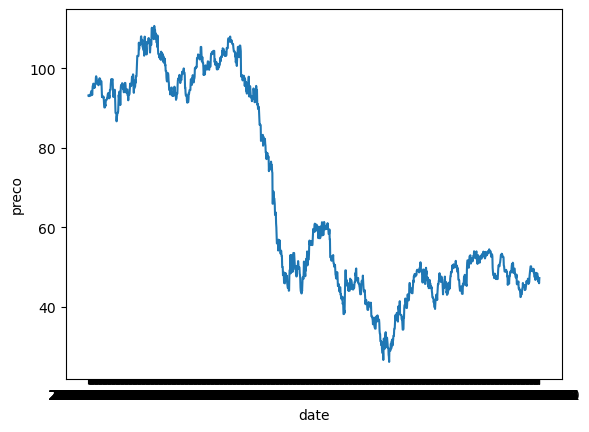

In [4]:
 sns.lineplot(data = preco_petroleo_todos, x= 'date', y = 'preco')

In [5]:
#Criando dicionário com cotação diária e criando colunas nos datasets de teste e treino

dicio_petroleo = {}
for i in preco_petroleo_todos.itertuples():
    dicio_petroleo[i.date] = i.preco

petroleo_treino = []
for i in dados_treino.itertuples():
    petroleo_treino.append(dicio_petroleo[i.date])
    
petroleo_teste = []
for i in dados_teste.itertuples():
    petroleo_teste.append(dicio_petroleo[i.date])
    
complete_data_treino = dados_treino
complete_data_treino['Petroleo'] = petroleo_treino

complete_data_teste = dados_teste
complete_data_teste['Petroleo'] = petroleo_teste


## Adicionando metadados das lojas 

**Falar sobre covariantes estáticas aqui**

In [6]:
complete_data_treino = pd.merge(complete_data_treino,lojas,how='inner',on = 'store_nbr')
complete_data_teste = pd.merge(complete_data_teste,lojas,how='inner',on = 'store_nbr')

# Organizando a sequência das séries

**Organizar as séries de forma multivariavel por loja**

In [7]:
serie_organized_data = pd.DataFrame(columns = complete_data_treino.columns.values )

In [8]:


for str in complete_data_treino['store_nbr'].unique():
    for f in complete_data_treino['family'].unique():
        train_serie1 = complete_data_treino.loc[(complete_data_treino['store_nbr']== str) & (complete_data_treino['family']== f)]
        break
    break



In [9]:
for str in complete_data_teste['store_nbr'].unique():
    for f in complete_data_teste['family'].unique():
        keagle_target = complete_data_teste.loc[(complete_data_teste['store_nbr']== str) & (complete_data_teste['family']== f)]
        break
    break


# Modelo com darts

**Explicar o porque usar o darts**
**Criar configuração XGboost**
**Encode e Normaliza**
**Criar modelo com darts**

# Testes e resultados 
**Scorre das predições**
**Visualização das predições**

## Apenas Uma serie univariada 

In [10]:
train_serie1.head()

,id,date,store_nbr,family,sales,onpromotion,Petroleo,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,93.14,Quito,Pichincha,D,13
33,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,93.14,Quito,Pichincha,D,13
66,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,92.97,Quito,Pichincha,D,13
99,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,93.12,Quito,Pichincha,D,13
132,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,93.20,Quito,Pichincha,D,13


In [11]:
train_serie1['date'] = pd.to_datetime(train_serie1['date'] )
train_serie1 = train_serie1.set_index('date')
petrol = train_serie1['Petroleo']

C:\Users\Felipe\AppData\Local\Temp\ipykernel_18628\3505481293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_serie1['date'] = pd.to_datetime(train_serie1['date'] )


### Train test Split

In [12]:
train_X = train_serie1[:1684-15]
train_Y = train_serie1[1684-15:]

In [13]:
from darts import TimeSeries
Validacao= TimeSeries.from_dataframe(train_Y,
                            value_cols = 'sales',
                            fill_missing_dates=True, )

In [14]:
train_X['sales'].isnull().sum()

0

### XGB

In [15]:
from darts.models import XGBModel


petrol_cotation = TimeSeries.from_series(petrol,fill_missing_dates=True)


serie_L1_automotive = TimeSeries.from_dataframe(train_X,
                                                value_cols = 'sales',
                                                fill_missing_dates=True,
                                                fillna_value=0)

t1 = serie_L1_automotive.add_datetime_attribute('weekday')


model = XGBModel(
    lags=15,
    lags_future_covariates=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],
    output_chunk_length=15,
)



model.fit(serie_L1_automotive,future_covariates=petrol_cotation)
pred = model.predict(15)




<Axes: xlabel='date'>

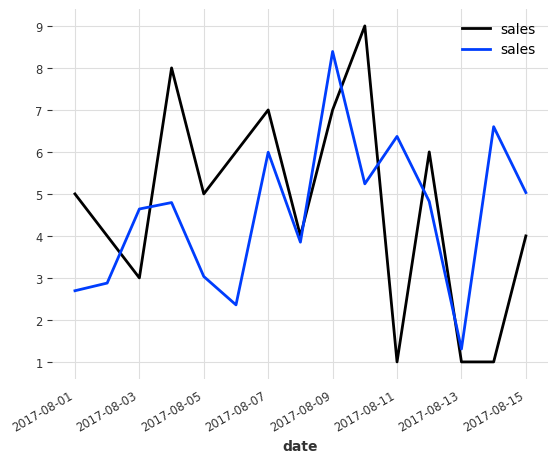

In [16]:
Validacao.plot()
pred.plot()